
# Convolutional Neural Network CNN
1. Using Glove implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [2]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [12]:
# original english file
filename  = '../../../Data/Fake news detection/data'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)

In [13]:
# Run only for English data 
orig_df["Body"] = orig_df["Body"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)
df = orig_df

In [14]:
df.head()

,Body,Label
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,The feud broke into public view last week when...,1
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,"Country singer Jason Aldean, who was performin...",1


### Class count

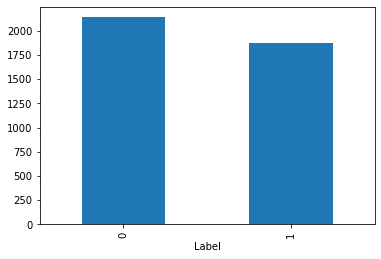

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [18]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

### Balanced Data

In [19]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [20]:
new_text, new_label = balanceClasses(df['Body'], df['Label'])

In [21]:
data = pd.DataFrame(new_text)
data.columns = ['Body']
data['Label'] = new_label
data = pd.concat([df, data])

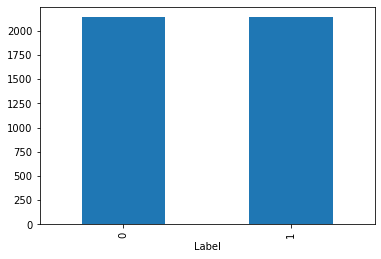

In [22]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [23]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [24]:

data=data.sample(frac=1).reset_index(drop=True)
data

,Body,Label
0,By Tony Cartalucci\n \nNothing is more deplora...,0
1,An Embattled Pharmaceutical Company That Sells...,0
2,Video\nThey were brought to the US illegally a...,1
3,IRS Still Going After Obama’s Political Foes a...,0
4,By Tony Cartalucci\nPerhaps the only thing mor...,0
...,...,...
4268,"Vietnam Is in Great Danger, You Must Publish a...",0
4269,"""Saturday Night Live"" kicked off its latest ep...",1
4270,Red Flag Warning: These California Wildfires A...,0
4271,"The husband of Kubra Golge, above, is among th...",1


### Data Preprocessing

In [25]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceFourColon(x))

In [26]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Body'] = data['Body'].apply(lambda x: textPattern(x))

In [27]:
data.shape

(4273, 2)

In [28]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Body]

In [29]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [30]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [31]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [32]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [33]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [35]:
zero  = []
one = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        
data['0']= zero
data['1']= one

data = data[['Text_Final', 'tokens', 'Label', '0', '1']]

In [36]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', 'Category_id' ]]
data.head(9)

,Text_Final,tokens,Label,0,1,Category_id
0,tony cartalucci nothing deplorable hijacking h...,"[tony, cartalucci, nothing, deplorable, hijack...",0,1,0,0
1,embattled pharmaceutical company sell powerful...,"[embattled, pharmaceutical, company, sell, pow...",0,1,0,0
2,video brought u illegally child - america plac...,"[video, brought, u, illegally, child, -, ameri...",1,0,1,1
3,irs still going obama political foe agency ass...,"[irs, still, going, obama, political, foe, age...",0,1,0,0
4,tony cartalucci perhaps thing incredible quick...,"[tony, cartalucci, perhaps, thing, incredible,...",0,1,0,0
5,washington cnn former white house chief strate...,"[washington, cnn, former, white, house, chief,...",1,0,1,1
6,trump push kneeling rule nfl news cdn : www co...,"[trump, push, kneeling, rule, nfl, news, cdn, ...",0,1,0,0
7,shop taipei taiwan ha charging 325 presidentia...,"[shop, taipei, taiwan, ha, charging, 325, pres...",1,0,1,1
8,frankfurt duesseldorf reuters - germany hochti...,"[frankfurt, duesseldorf, reuters, -, germany, ...",1,0,1,1


In [37]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 20 % for testing. We use random state so every time we get the same training and testing data.

In [38]:
data.shape

(4273, 6)

In [39]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [40]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Glove model

In [41]:
# word2vec_path = 'GoogleNews-vectors-negative300.bin'
# #word2vec_path = 'glove.6B.50d.word2vec'

In [42]:
# from gensim import models
# word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [43]:
# Convert Glove file to word2vec format (examples: uses 50 dimensions since it's faster)
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'  # I unzipped in glove.6B subdirectory 
word2vec_output_file = 'glove.6B.300d.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-43-94d1a7902d0c>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 300)

In [44]:
# Use the converted Glove file


filename = 'glove.6B.300d.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)


In [45]:
word2vec

In [46]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [47]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 39491 unique tokens.


In [48]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [49]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(39492, 300)


In [50]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [51]:
label_names = ['0', '1']

In [52]:
from tensorflow.keras import optimizers
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [53]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [54]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [55]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [56]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     11847600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 149, 512)     307712      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 512)     461312      embedding[0][0]                  
_______________________________________________________________________________________

### Train CNN

In [57]:
num_epochs = 100
batch_size = 32

In [58]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/100
109/109 [==============================] - 50s 457ms/step - loss: 0.9099 - accuracy: 0.8471 - val_loss: 0.0770 - val_accuracy: 0.9714
Epoch 2/100
109/109 [==============================] - 53s 482ms/step - loss: 0.1015 - accuracy: 0.9682 - val_loss: 0.0427 - val_accuracy: 0.9844
Epoch 3/100
109/109 [==============================] - 62s 569ms/step - loss: 0.0670 - accuracy: 0.9832 - val_loss: 0.0534 - val_accuracy: 0.9896
Epoch 4/100
109/109 [==============================] - 60s 555ms/step - loss: 0.0643 - accuracy: 0.9882 - val_loss: 0.0449 - val_accuracy: 0.9896
Epoch 5/100
109/109 [==============================] - 60s 549ms/step - loss: 0.0331 - accuracy: 0.9934 - val_loss: 0.0674 - val_accuracy: 0.9896
Epoch 6/100
109/109 [==============================] - 49s 451ms/step - loss: 0.0627 - accuracy: 0.9899 - val_loss: 0.0777 - val_accuracy: 0.9896
Epoch 7/100
109/109 [==============================] - 46s 424ms/step - loss: 0.0311 - accuracy: 0.9954 - val_loss: 0.1518 -

Epoch 57/100
109/109 [==============================] - 48s 439ms/step - loss: 0.0134 - accuracy: 0.9986 - val_loss: 0.2671 - val_accuracy: 0.9896
Epoch 58/100
109/109 [==============================] - 46s 424ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.3433 - val_accuracy: 0.9896
Epoch 59/100
109/109 [==============================] - 46s 427ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.2146 - val_accuracy: 0.9896
Epoch 60/100
109/109 [==============================] - 469s 4s/step - loss: 0.0148 - accuracy: 0.9983 - val_loss: 0.1802 - val_accuracy: 0.9922
Epoch 61/100
109/109 [==============================] - 56s 511ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.1794 - val_accuracy: 0.9948
Epoch 62/100
109/109 [==============================] - 46s 427ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.3974 - val_accuracy: 0.9870
Epoch 63/100
109/109 [==============================] - 45s 417ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.3

In [59]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

14/14 [==============================] - 2s 147ms/step - loss: 0.1934 - accuracy: 0.9930


In [60]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 964us/step


### Testing few sentences using our model

In [61]:

labels = ['0', '1']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [62]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [63]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.9929906542056075

In [64]:
data_test.Label.value_counts()

1    230
0    198
Name: Label, dtype: int64

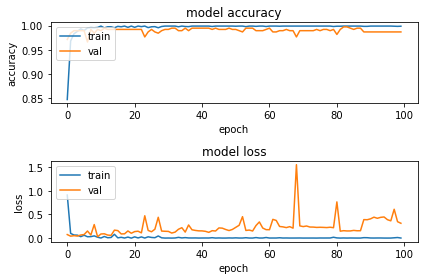

In [65]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [66]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[196   2]
 [  1 229]]
Accuracy Score : 0.9929906542056075
Report : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       198
           1       0.99      1.00      0.99       230

    accuracy                           0.99       428
   macro avg       0.99      0.99      0.99       428
weighted avg       0.99      0.99      0.99       428



                        Convolution Neural Network


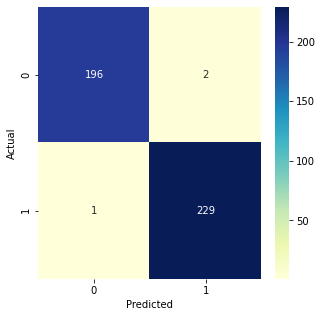

In [67]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [68]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics
import tensorflow as tf
import random

f_score=[]
fold = 10
label_names = ['0', '1']
num_epochs = 5
batch_size = 32
#oos_y = []
#oos_pred = []
results = []
#for train, test in kf.split(data["tokens"], data['Label']):

for i in range(fold):
    print("Fold: ", i+1)
    random_num = np.random.randint(1,7000, 1)[0]
    data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True, random_state = random_num)

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    # create model
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    
    #Train Model
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
      
    # model evaluate
    
    print("Results for current fold:")
    results.append(model.evaluate(x_test, y_tst, batch_size=128))

#     predictions = model.predict(cnnTestData, batch_size=1024, verbose=0)
#     oos_y.append(y_test)
#     oos_pred.append(predictions)
    
    #score = np.sqrt(metrics.mean_squared_error(predictions, y_test))
#    f_score.append(count)

model.save('model_CNN.h5')    

Fold:  1
Epoch 1/5
109/109 [==============================] - 44s 403ms/step - loss: 1.0181 - accuracy: 0.8439 - val_loss: 0.4145 - val_accuracy: 0.9091
Epoch 2/5
109/109 [==============================] - 44s 405ms/step - loss: 0.1439 - accuracy: 0.9616 - val_loss: 0.1534 - val_accuracy: 0.9610
Epoch 3/5
109/109 [==============================] - 44s 406ms/step - loss: 0.0704 - accuracy: 0.9870 - val_loss: 0.0787 - val_accuracy: 0.9870
Epoch 4/5
109/109 [==============================] - 44s 405ms/step - loss: 0.1055 - accuracy: 0.9855 - val_loss: 0.6631 - val_accuracy: 0.9039
Epoch 5/5
109/109 [==============================] - 44s 408ms/step - loss: 0.0613 - accuracy: 0.9931 - val_loss: 0.1156 - val_accuracy: 0.9870
Results for current fold:
4/4 [==============================] - 1s 370ms/step - loss: 0.0918 - accuracy: 0.9883
Fold:  2
Epoch 1/5
109/109 [==============================] - 44s 406ms/step - loss: 0.8135 - accuracy: 0.8529 - val_loss: 0.3007 - val_accuracy: 0.9273
Epoch

In [69]:
import statistics 
# for i in range(len(results)):
#     print("Fold: ", i+1)
#     print("test loss, test acc:", results[i])

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.9808411121368408


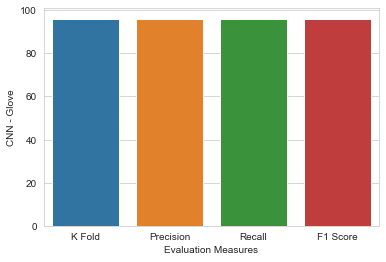

In [70]:
# for Glove
import pandas as pd
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['CNN - Glove']=[96, 96, 96, 96]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'CNN - Glove',data=results)

### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
